# 

# 1. Data Preparation
## 1. Feature Selection
Before we can partition our data, we need to select only the targeted features in the specification. This step requires us to select the appropriate features within the data and further clean it before we are ready to train

In [39]:
import os
from pathlib import Path as path
from collections import Counter
import glob
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import featuretools as ft
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    StratifiedShuffleSplit,
    train_test_split
)

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

In order to simplify repertory changes, we'll initialize two variables, containning the paths of this current repository and the path of your clone of the Apache Hive repertory.

In [2]:
project_repo = path("/home/nicolas-richard/Desktop/.Apache_Hive_Bug_Prediction_ML_Model")
hive_repo = path("/home/nicolas-richard/Desktop/.Apache_Hive")

In [3]:
def extract_version(filename):
    file_part = filename.split('/')[-1]

    parts = file_part.split('-')
    if len(parts) < 2:
        raise ValueError("Filename does not contain a version segment.")

    version_part = parts[1].split('_')[0]
    return version_part

In [4]:
input_files = glob.glob(os.path.join(project_repo, 'UND_hive_updated_data', '*.csv'))

concatenated_df = pd.DataFrame()

for file in input_files:
    df = pd.read_csv(file)
    
    version = extract_version(file)
    df.insert(loc=2, column='Version', value=version)
    concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)

concatenated_df.info()
count = concatenated_df['Version'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147744 entries, 0 to 147743
Data columns (total 100 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Bug                                 147744 non-null  int64  
 1   FileName                            147744 non-null  object 
 2   Version                             147744 non-null  object 
 3   AvgCountLine                        147744 non-null  float64
 4   AvgCountLineBlank                   147744 non-null  float64
 5   AvgCountLineCode                    147744 non-null  float64
 6   AvgCountLineComment                 147744 non-null  float64
 7   AvgCyclomatic                       147744 non-null  float64
 8   AvgCyclomaticModified               147744 non-null  float64
 9   AvgCyclomaticStrict                 147744 non-null  float64
 10  AvgCyclomaticStrictModified         147744 non-null  float64
 11  AvgEssential             

In [5]:
print(concatenated_df['Version'].nunique())
concatenated_df.info()

23
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147744 entries, 0 to 147743
Data columns (total 100 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Bug                                 147744 non-null  int64  
 1   FileName                            147744 non-null  object 
 2   Version                             147744 non-null  object 
 3   AvgCountLine                        147744 non-null  float64
 4   AvgCountLineBlank                   147744 non-null  float64
 5   AvgCountLineCode                    147744 non-null  float64
 6   AvgCountLineComment                 147744 non-null  float64
 7   AvgCyclomatic                       147744 non-null  float64
 8   AvgCyclomaticModified               147744 non-null  float64
 9   AvgCyclomaticStrict                 147744 non-null  float64
 10  AvgCyclomaticStrictModified         147744 non-null  float64
 11  AvgEssential          

In [6]:
concatenated_df.drop_duplicates
data = concatenated_df.iloc[:,[0,7,8,9,11,3,4,5,6,20,21,22,27,28,29,33,36,38,39,
                               40,42,43,44,45,46,47,53,54,55,57,64,65,66,75,76,
                               77,78,80,16,17,19,70,73,82,83,84,85,86,87,88,89,
                               90,91,92,93]]
data.dropna(inplace=True)
data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147340 entries, 0 to 147339
Data columns (total 55 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Bug                        147340 non-null  int64  
 1   AvgCyclomatic              147340 non-null  float64
 2   AvgCyclomaticModified      147340 non-null  float64
 3   AvgCyclomaticStrict        147340 non-null  float64
 4   AvgEssential               147340 non-null  float64
 5   AvgCountLine               147340 non-null  float64
 6   AvgCountLineBlank          147340 non-null  float64
 7   AvgCountLineCode           147340 non-null  float64
 8   AvgCountLineComment        147340 non-null  float64
 9   CountDeclClass             147340 non-null  float64
 10  CountDeclClassMethod       147340 non-null  float64
 11  CountDeclClassVariable     147340 non-null  float64
 12  CountDeclFunction          147340 non-null  float64
 13  CountDeclInstanceMethod    14

We now have 55 columns. This includes all the *46 independent variables* at study (37 related to files, 5 related to classes and 4 related to methods (expanded to 12 for simplicity's sake) mentionned in *Yatish et al., 2019*) in addition to the first column, specify whether there is a bug in a given file. The dataframe is structured as follows

In [7]:
profile = ProfileReport(data, 
                        title='Apache Hive Bug Dataset Profile Report',
                        pool_size=4,
                        html={'style': {'full_width': True}},
                        minimal=True)
profile.to_notebook_iframe()
data.to_csv("Data_Preparation_Output.csv",index=False)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2. Outlier Detection and Handling
In this step, we'll get rid of the outliers within our data

In [8]:
numeric_features = data.select_dtypes(include=['float64']).columns.tolist()

def remove_outliers(df, numeric_cols, std_threshold=3):
    df_clean = data.copy()
    
    for col in numeric_cols:
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        df_clean = df_clean[abs(df_clean[col] - mean) <= std_threshold * std]
    
    return df_clean

data = remove_outliers(data, numeric_features)

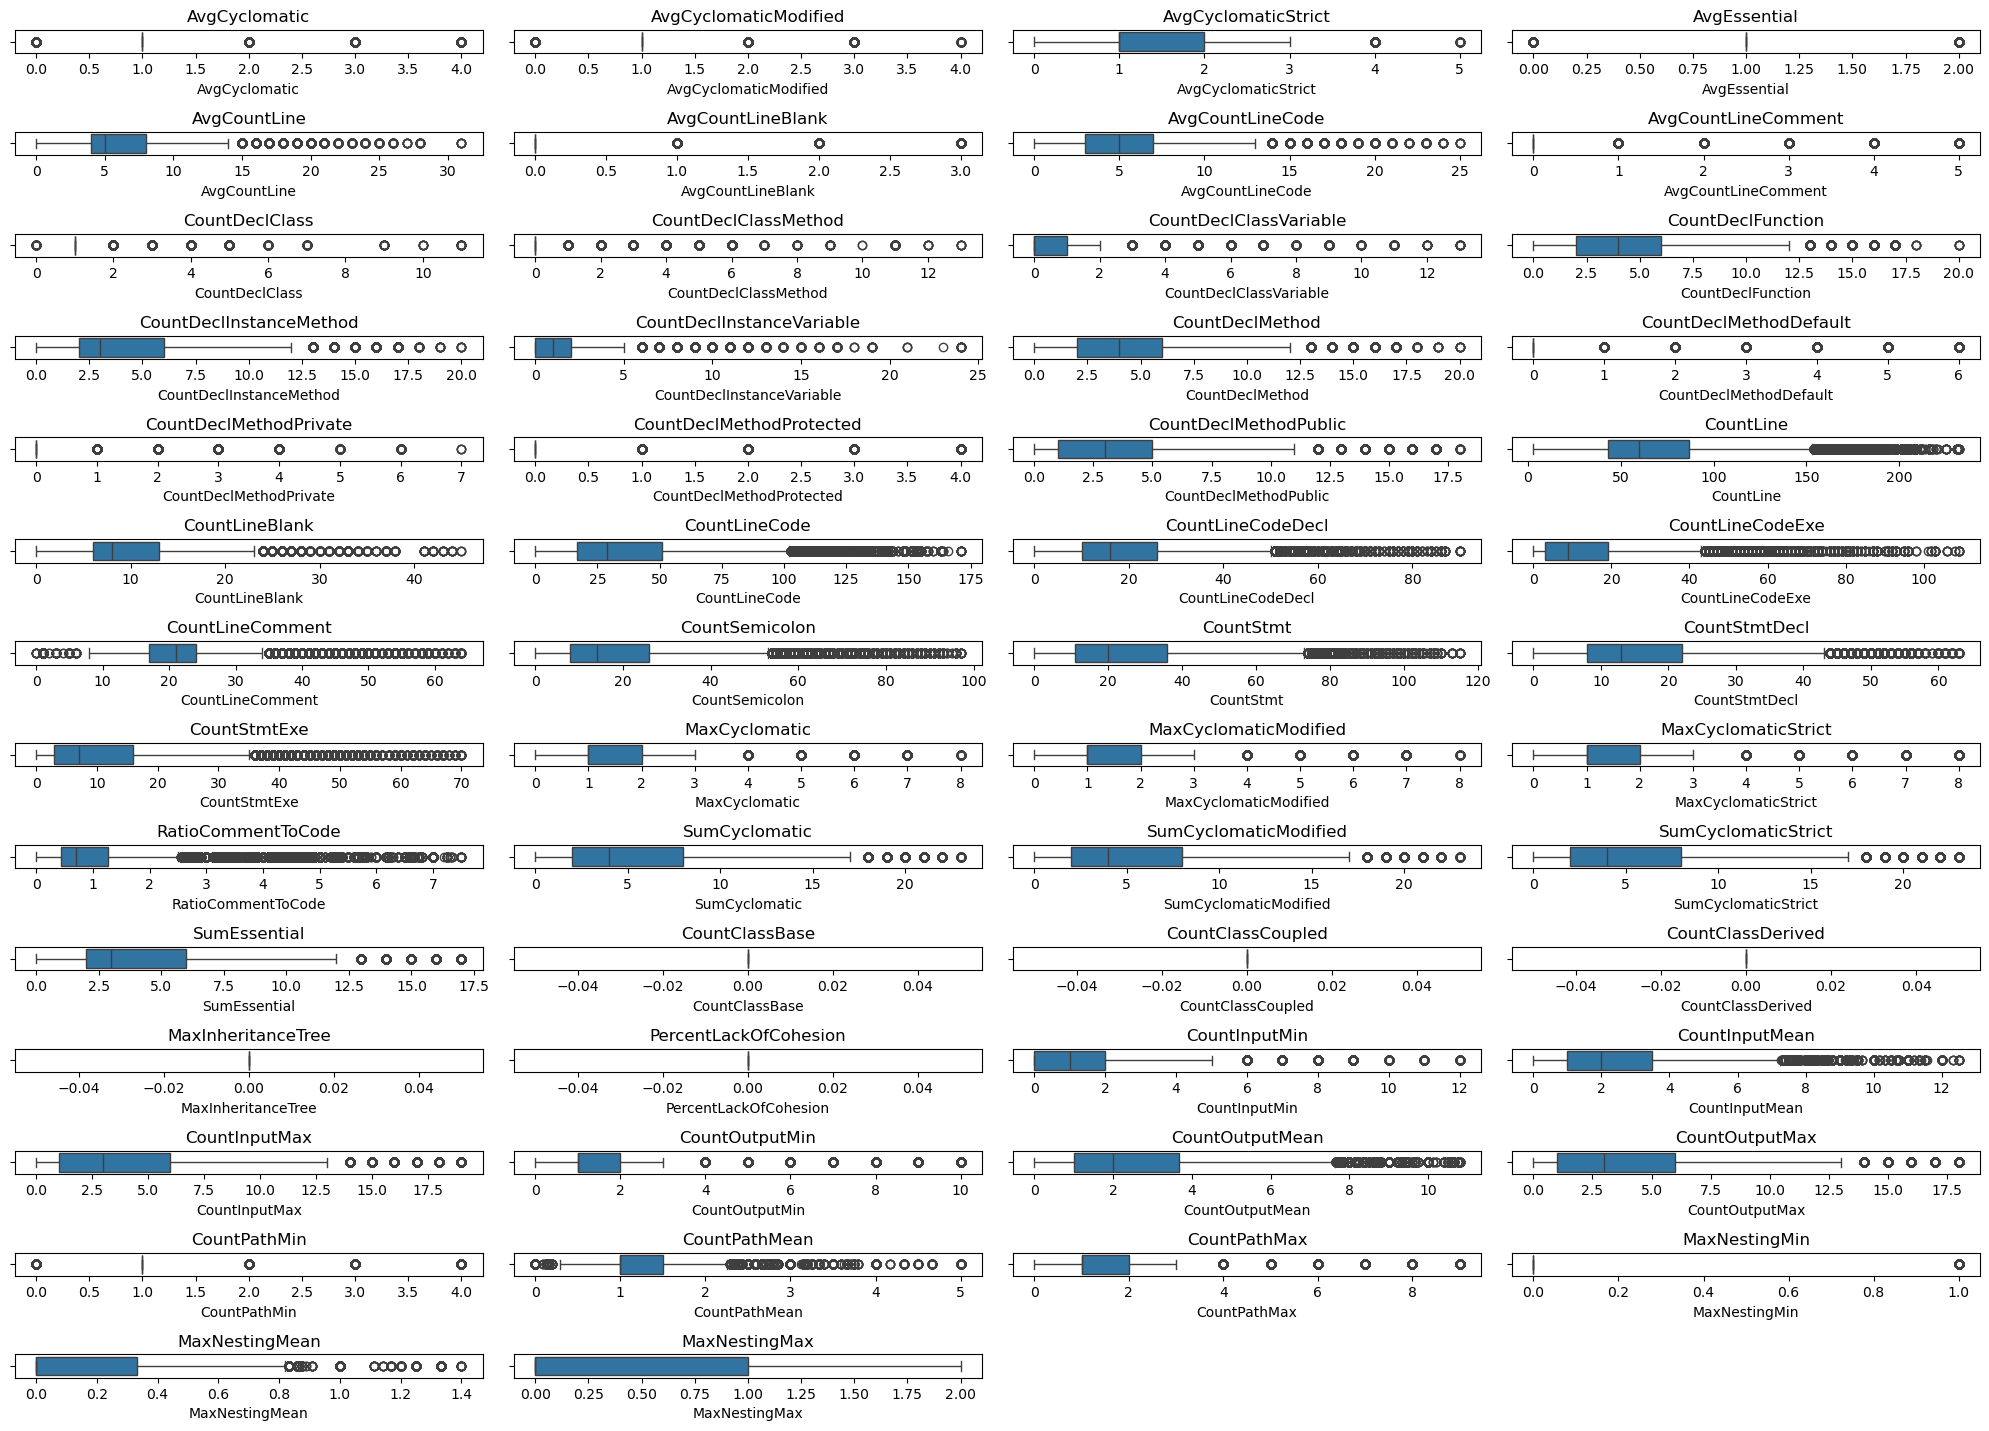

In [9]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(15, 4, i)
    sns.boxplot(x=data[feature])
    plt.title(f'{feature}')
plt.tight_layout()
plt.show()

## 3. Data Partitionning
As per the specification of the project, we'll need to test different train-test partitions. We'll settle on a given partition size for each trainning model in the following notebook. We need to do the following at this point in order to follow-up with data engineering.
We have setttled on the following partition train-test partion sizes:
- 30 - 70
- 50 - 50
- 70 - 30
- 80 - 20
- 90 - 10

As we have a highly unbalanced dataset, we'll use Stratified Shuffle Split

In [10]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

X = data.drop('Bug', axis=1)
Y = data['Bug']

for train_index, test_index in sss.split(X, Y):
    X_train_full, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_full, y_test = Y.iloc[train_index], Y.iloc[test_index]

train_sizes = [0.3, 0.5, 0.7, 0.8, 0.9]
train_subsets = []

for size in train_sizes:
    sss_subset = StratifiedShuffleSplit(n_splits=1, train_size=size, random_state=42)
    for train_subset_index, _ in sss_subset.split(X_train_full, y_train_full):
        X_train_subset = X_train_full.iloc[train_subset_index]
        Y_train_subset = y_train_full.iloc[train_subset_index]
        train_subsets.append((X_train_subset, Y_train_subset))

for i, (X_subset, Y_subset) in enumerate(train_subsets):
    print(f"\nTraining Size {train_sizes[i]*100}% - Class Distribution:\n", Y_subset.value_counts(normalize=True))


Training Size 30.0% - Class Distribution:
 Bug
0    0.992689
1    0.007311
Name: proportion, dtype: float64

Training Size 50.0% - Class Distribution:
 Bug
0    0.992677
1    0.007323
Name: proportion, dtype: float64

Training Size 70.0% - Class Distribution:
 Bug
0    0.992672
1    0.007328
Name: proportion, dtype: float64

Training Size 80.0% - Class Distribution:
 Bug
0    0.992682
1    0.007318
Name: proportion, dtype: float64

Training Size 90.0% - Class Distribution:
 Bug
0    0.992669
1    0.007331
Name: proportion, dtype: float64


## 4. Feature & Correlation Analysis
Here, we want to remove low variance features in or trainning sets and to identify and remove highly correlated features


Subset 1: Training Size 30.0%


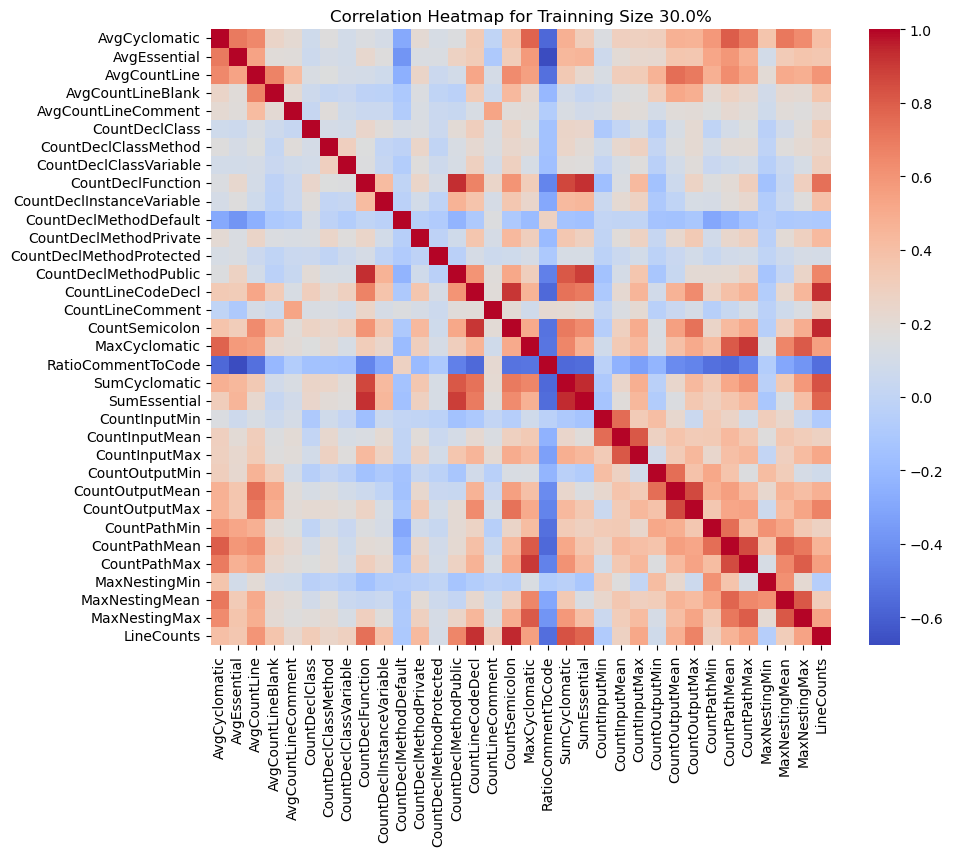

Highly Correlated Features: ['CountDeclMethodPublic', 'CountSemicolon', 'SumEssential', 'CountPathMax', 'LineCounts']
Subset 1 after dropping correlated features: (16140, 29)

Subset 2: Training Size 50.0%


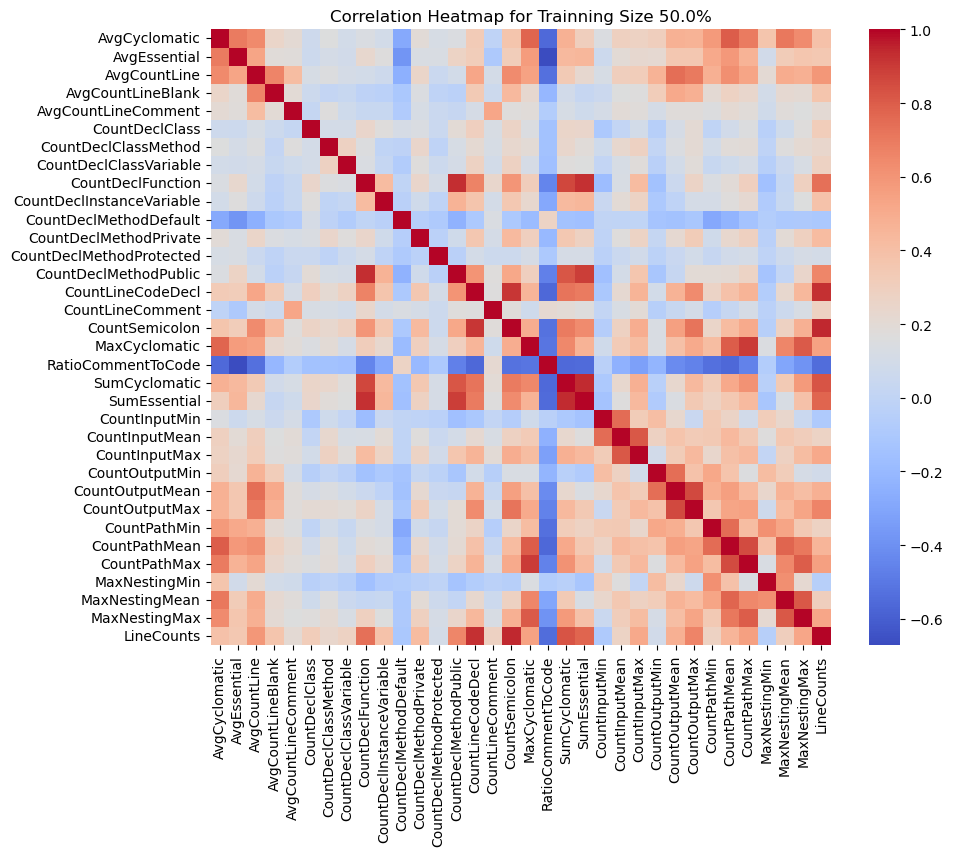

Highly Correlated Features: ['CountDeclMethodPublic', 'CountSemicolon', 'SumEssential', 'CountPathMax', 'LineCounts']
Subset 2 after dropping correlated features: (26901, 29)

Subset 3: Training Size 70.0%


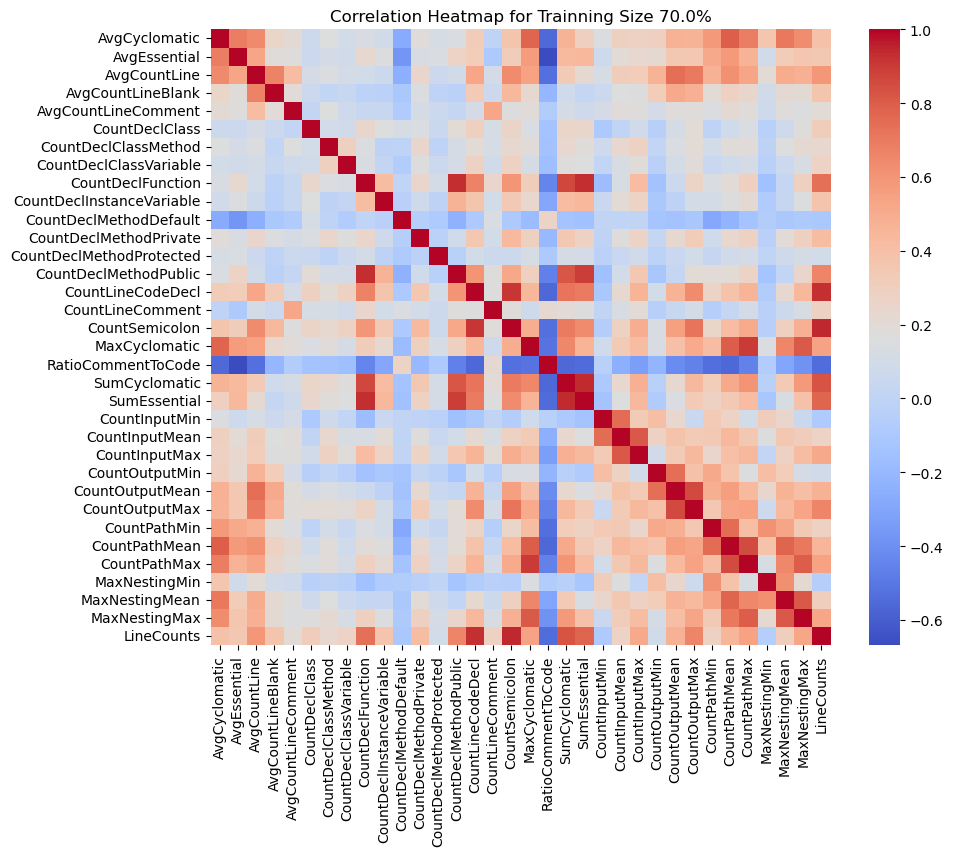

Highly Correlated Features: ['CountDeclMethodPublic', 'CountSemicolon', 'SumEssential', 'CountPathMax', 'LineCounts']
Subset 3 after dropping correlated features: (37662, 29)

Subset 4: Training Size 80.0%


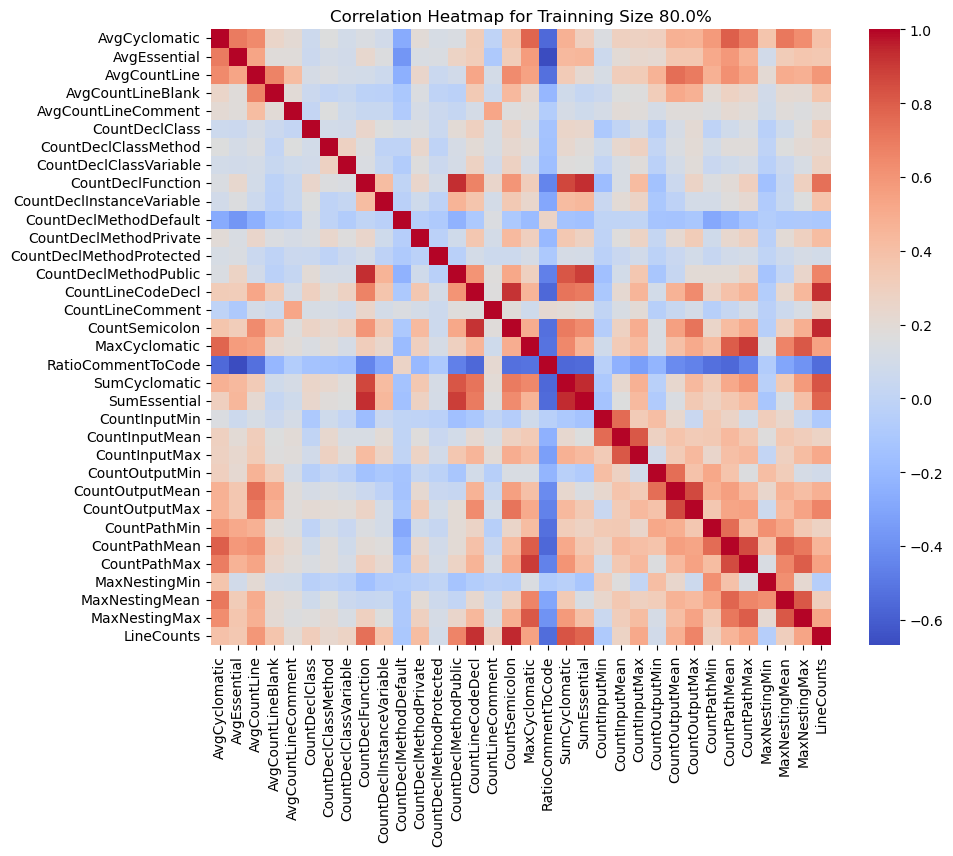

Highly Correlated Features: ['CountDeclMethodPublic', 'CountSemicolon', 'SumEssential', 'CountPathMax', 'LineCounts']
Subset 4 after dropping correlated features: (43042, 29)

Subset 5: Training Size 90.0%


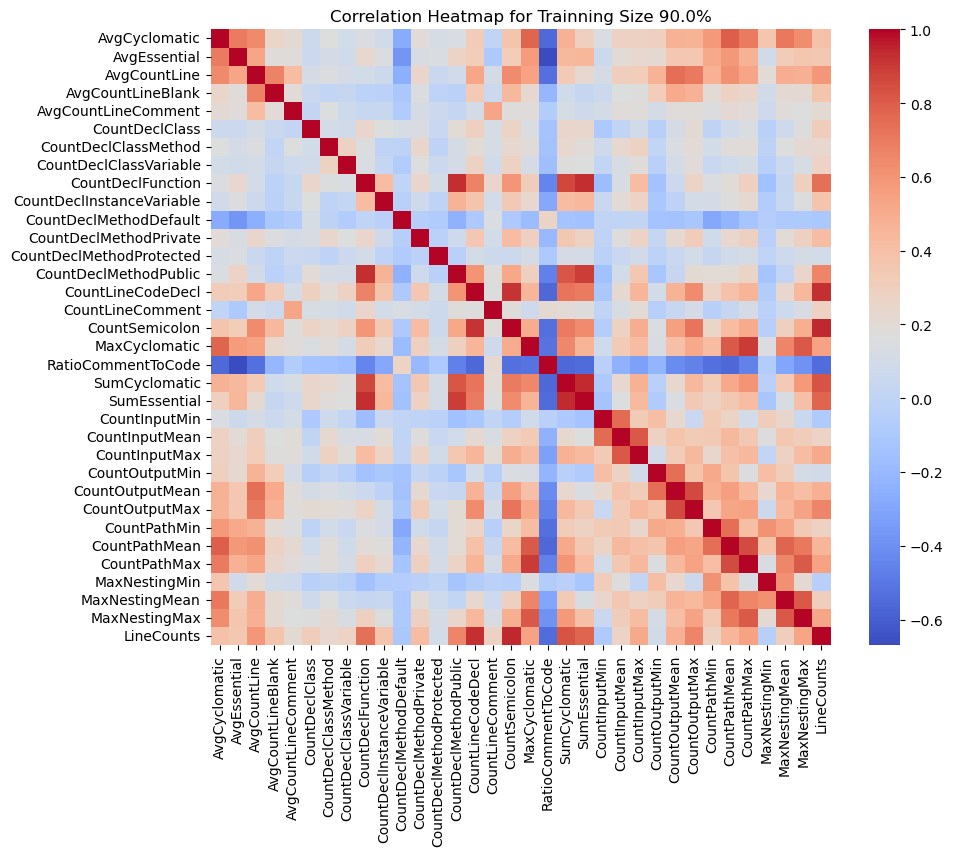

Highly Correlated Features: ['CountDeclMethodPublic', 'CountSemicolon', 'SumEssential', 'LineCounts']
Subset 5 after dropping correlated features: (48422, 30)


In [27]:
for i, (X_subset, Y_subset) in enumerate(train_subsets):
    print(f"\nSubset {i+1}: Training Size {train_sizes[i]*100}%")
    corr_matrix = X_subset.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f")
    plt.title(f"Correlation Heatmap for Trainning Size {train_sizes[i]*100}%")
    plt.show()

    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    highly_corr_features = [
        column for column in upper_triangle.columns if any(upper_triangle[column].abs() > 0.9)
    ]
    print("Highly Correlated Features:", highly_corr_features)

    X_subset_dropped = X_subset.drop(columns=highly_corr_features)
    print(f"Subset {i+1} after dropping correlated features: {X_subset_dropped.shape}")

    X_subset = X_subset_dropped

## 5. *ADASYN* for Oversampling

In [30]:
adasyn = ADASYN(random_state=42)

for i, (X_subset, Y_subset) in enumerate(train_subsets):
    X_subset, Y_subset = adasyn.fit_resample(X_subset, Y_subset)
    
    print(f"Class distribution after ADASYN:\n{pd.Series(Y_subset).value_counts(normalize=True)}")


Class distribution after ADASYN:
Bug
0    0.500562
1    0.499438
Name: proportion, dtype: float64
Class distribution after ADASYN:
Bug
1    0.500365
0    0.499635
Name: proportion, dtype: float64
Class distribution after ADASYN:
Bug
1    0.500421
0    0.499579
Name: proportion, dtype: float64
Class distribution after ADASYN:
Bug
1    0.500357
0    0.499643
Name: proportion, dtype: float64
Class distribution after ADASYN:
Bug
0    0.500187
1    0.499813
Name: proportion, dtype: float64


# 2 - Trainning with Cross-Validation

## 2.1 - Logistic Regression

In [40]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

log_reg = LogisticRegression(
    solver='saga',
    penalty='elasticnet',
    max_iter=100000,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)

rfecv_log_reg = RFECV(
    estimator=log_reg,
    step=1,
    cv=cv,
    scoring='roc_auc',
    verbose=0,
    n_jobs=-1,
    min_features_to_select=1
)

rfecv_log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfecv', rfecv_log_reg)
])

param_grid = {
    'rfecv__estimator__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  
}

grid_search = GridSearchCV(
    estimator=rfecv_log_reg_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

for i, (X_subset, Y_subset) in enumerate(train_subsets):
    print(f"\nTraining on Subset {train_sizes[i] * 100}%")

    grid_search.fit(X_subset, Y_subset)

    best_pipeline = grid_search.best_estimator_
    print(f"Best l1_ratio for Subset {i + 1}: {grid_search.best_params_['rfecv__estimator__l1_ratio']}")

    y_pred_log_reg = best_pipeline.predict(X_subset)
    y_pred_proba_log_reg = best_pipeline.predict_proba(X_subset)[:, 1]

    roc_auc = roc_auc_score(Y_subset, y_pred_proba_log_reg)
    print(f"ROC-AUC Score for Logistic Regression on Subset {i + 1}: {roc_auc:.4f}")
    print(classification_report(Y_subset, y_pred_log_reg, zero_division=1))


Training on Subset 30.0%
Fitting 3 folds for each of 5 candidates, totalling 15 fits


KeyboardInterrupt: 

## 2. Random Forest

In [41]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_forest = RandomForestClassifier(
    n_estimators=15000,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

rfecv_rf = RFECV(
    estimator=random_forest,
    step=1,
    cv=cv,
    scoring='roc_auc',
    verbose=0,
    n_jobs=-1,
    min_features_to_select=1
)

variance_threshold = VarianceThreshold(threshold=0.01)
rfecv_rf_pipeline = Pipeline([
    ('variance_threshold', variance_threshold),
    ('scaler', StandardScaler()),
    ('rfecv', rfecv_rf)
])

param_grid = {
    'rfecv__estimator__n_estimators': [500, 1000, 1500],
    'rfecv__estimator__max_depth': [None, 10, 20],
    'rfecv__estimator__min_samples_split': [2, 5, 10],
    'rfecv__estimator__min_samples_leaf': [1, 5, 10],
    'rfecv__estimator__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=rfecv_rf_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

for i, (X_subset, Y_subset) in enumerate(train_subsets):
    print(f"\nTraining on Subset {i + 1}:")

    grid_search.fit(X_subset, Y_subset)

    best_pipeline = grid_search.best_estimator_
    print(f"Best Parameters for Subset {i + 1}: {grid_search.best_params_}")

    y_pred_rf = best_pipeline.predict(X_subset)
    y_pred_proba_rf = best_pipeline.predict_proba(X_subset)[:, 1]

    roc_auc = roc_auc_score(Y_subset, y_pred_proba_rf)
    print(f"ROC-AUC Score for Random Forest on Subset {i + 1}: {roc_auc:.4f}")
    print(classification_report(Y_subset, y_pred_rf, zero_division=1))

    selected_features = best_pipeline.named_steps['rfecv'].support_
    print(f"Selected Features for Subset {i + 1}: {X_subset.columns[selected_features].tolist()}")


Training on Subset 1:
Fitting 3 folds for each of 162 candidates, totalling 486 fits


KeyboardInterrupt: 